In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



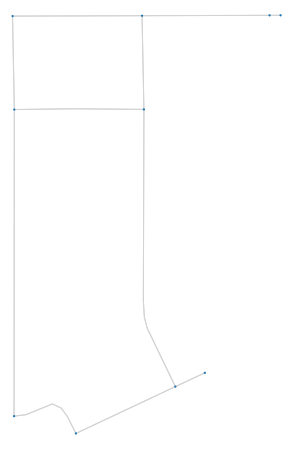

KeyboardInterrupt: 

In [469]:

#Creating a bounding box
north, south, east, west = 43.146918,43.150018,-77.646432,-77.643836
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
#G = ox.graph_from_place('Rochester, NY, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(start1)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines       
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)




/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



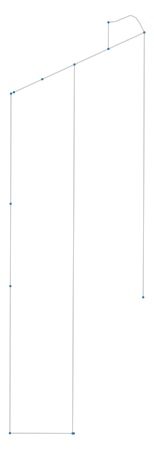

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/f0395b6fd31b49bc8102b9d574cc9c47-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/f0395b6fd31b49bc8102b9d574cc9c47-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 163 COLUMNS
At line 1364 RHS
At line 1523 BOUNDS
At line 1692 ENDATA
Problem MODEL has 158 rows, 168 columns and 708 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1241.05 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 132 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 132 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 132 strengthened rows, 0 substitutions
Cgl

In [77]:
#FIRST AGAIN____
#Creating a bounding box
north, south, east, west = 43.142237,43.147200,-77.648127,-77.645767
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
#G = ox.graph_from_place('Rochester, NY, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(start1)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines       
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)





In [78]:
path1=pathlist

In [79]:
path1

[212673147.0,
 212624950,
 212624950.0,
 212673147,
 212765253,
 212765248,
 212787670,
 5842737587.0,
 5842737587.0,
 212787670,
 212787670.0,
 212719149,
 212719149.0,
 212719146,
 212719146.0,
 212679968,
 212679968.0,
 5842735673,
 5842735673.0,
 7202733160,
 7202733160.0,
 212668635,
 212668635.0,
 212765248,
 212765248.0,
 212765253,
 8038998601.0,
 8038998601.0,
 212765253,
 212765253.0,
 212673147]

In [5]:
#finalroutes = []

In [6]:
#bb = []
#bb1 = [-77.566137,43.174168,-77.561975,43.176296]
#bb2 = [-77.565536,43.169786,-77.559657,43.171602]
#b.append(bb1)
#b.append(bb2)

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



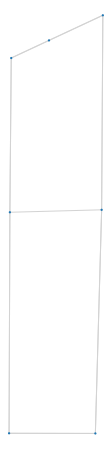

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/7e747138094c4cc88532eb1cf09d7480-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/7e747138094c4cc88532eb1cf09d7480-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 49 COLUMNS
At line 362 RHS
At line 407 BOUNDS
At line 456 ENDATA
Problem MODEL has 44 rows, 48 columns and 174 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 986.129 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 30 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 30 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 30 strengthened rows, 0 substitutions
Cgl0003I 0 f

In [7]:

#Creating a bounding box
north, south, east, west = 43.143614,43.149031,-77.642269,-77.640467 
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
#G = ox.graph_from_place('Rochester, NY, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(start1)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines       
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)



In [8]:
path2=pathlist

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



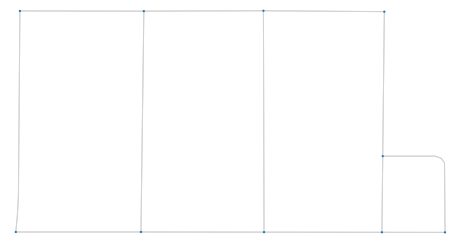

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/f4f596d094f74c038b00678672cd9e2e-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/f4f596d094f74c038b00678672cd9e2e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 97 COLUMNS
At line 782 RHS
At line 875 BOUNDS
At line 975 ENDATA
Problem MODEL has 92 rows, 99 columns and 396 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1041.92 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 f

uts average 2.0 elements, 0 column cuts (0 active)  in 0.001 seconds - new frequency is -100
Cbc0014I Cut generator 6 (TwoMirCuts) - 84 row cuts average 10.5 elements, 0 column cuts (0 active)  in 0.002 seconds - new frequency is 1
Cbc0014I Cut generator 7 (ZeroHalf) - 19 row cuts average 11.3 elements, 0 column cuts (0 active)  in 0.028 seconds - new frequency is 1
Cbc0001I Search completed - best objective 1071.2, took 70 iterations and 0 nodes (0.19 seconds)
Cbc0035I Maximum depth 0, 68 variables fixed on reduced cost
Cuts at root node changed objective from 1042.73 to 1056.28
Probing was tried 4 times and created 129 cuts of which 0 were active after adding rounds of cuts (0.002 seconds)
Gomory was tried 3 times and created 18 cuts of which 0 were active after adding rounds of cuts (0.001 seconds)
Knapsack was tried 3 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.001 seconds)
Clique was tried 3 times and created 0 cuts of which 0 were active after a

In [10]:

#Creating a bounding box
north, south, east, west = 43.142049,43.144241,-77.646089,-77.641239
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
#G = ox.graph_from_place('Rochester, NY, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(start1)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines       
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)




In [11]:
path3=pathlist

In [81]:
mainpath=path1+path2+path3

In [82]:
path1

[212673147.0,
 212624950,
 212624950.0,
 212673147,
 212765253,
 212765248,
 212787670,
 5842737587.0,
 5842737587.0,
 212787670,
 212787670.0,
 212719149,
 212719149.0,
 212719146,
 212719146.0,
 212679968,
 212679968.0,
 5842735673,
 5842735673.0,
 7202733160,
 7202733160.0,
 212668635,
 212668635.0,
 212765248,
 212765248.0,
 212765253,
 8038998601.0,
 8038998601.0,
 212765253,
 212765253.0,
 212673147]

In [83]:
path2

[212650634.0,
 212765270,
 212765270.0,
 212765265,
 212765265.0,
 212765262,
 212765262.0,
 212650636,
 212650636.0,
 212624944,
 212624944.0,
 212624940,
 212624940.0,
 212650634]

In [84]:
path3

[212624944.0,
 7199136342,
 7199136342.0,
 212787665,
 212787665.0,
 7199136346,
 7199136346.0,
 212787665,
 212787668.0,
 212787668.0,
 212624740,
 212624740.0,
 212673089,
 212673089.0,
 212624950,
 212624950.0,
 212624737,
 212624737.0,
 212624947,
 212624947.0,
 212624944]

In [85]:
#G = ox.graph_from_place('Rochester, NY, USA', network_type='drive_service')

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



In [384]:
G = ox.graph_from_place('Rochester, NY', network_type='drive_service')

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



In [385]:
path12 = nx.shortest_path(G,212673147,212650634, weight='travel_time')

In [386]:
path23 = nx.shortest_path(G,212650634,212624944, weight='travel_time')

In [387]:


path12

[212673147, 212624950, 212624737, 212624947, 212624944, 212624940, 212650634]

In [388]:
path12[1:-1]

[212624950, 212624737, 212624947, 212624944, 212624940]

In [389]:
path23

[212650634, 212624940, 212624944]

In [390]:
path23[1:-1]

[212624940]

In [391]:
mainroute = path1+path12[1:-1]+path2+path23[1:-1]+path3

In [392]:
mainroute1 = []
for i in mainroute:
    mainroute1.append(int(i))

In [393]:
#mainroute1 = []
#for i in mainroute:
#    if i != 7085465650:
#        mainroute1.append(int(i))
    

In [394]:
lines = node_list_to_path2(G, mainroute1)

In [395]:
long2 = []
lat2 = []

In [396]:
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])

In [397]:
plot_path(lat2, long2, origin_point, destination_point)

In [398]:
len(mainroute1)

72

In [399]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import geopandas as gpd
from geopandas.tools import geocode
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
locator = Nominatim(user_agent="myGeocoder")
#geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

In [400]:
rpd1="Irondequoit Police Department, 1300, Titus Ave, Rochester, NY, 14617"
rpd2="Police Department-Patrol Section Office, 630, North Clinton Avenue, Rochester, NY, 14605"
#rpd2="Goodman Section Office, 630, North Clinton Avenue, Rochester, NY, 14605"
rpd3="Lake Section, Rochester Police Department, 1099, Jay St 100D, Rochester, NY, 14611"
rpd3="Rochester Police Department Special Operations Division, 261, Child St, Rochester, NY, 14611"
rpd4="New York State Police - Troop E SP Rochester, 1155, Scottsville Rd, Rochester, NY, 14624"
rpd5="East Rochester Police Department, 317, Main St, East Rochester, NY, 14445"
rpd6="Brighton Police Department,2300, Elmwood Ave, Rochester, NY, 14618"
rpd7="Rochester Police Department, 184, Verona St, Rochester, NY, 14608"
rpd8="Rochester Police Department, 185, Exchange Boulevard, Rochester, NY, 14614"
rpd9="Central Section Rochester Police Department, 30, North Clinton Ave, Rochester, NY, 14604"

In [401]:
geolocator = Nominatim(user_agent="example app")

In [402]:
PoliceSitelist = [rpd1,rpd2,rpd3,rpd4,rpd5,rpd6,rpd7,rpd8,rpd9]
pst= pd.DataFrame([rpd.split(",") for rpd in PoliceSitelist])
pst.rename(columns={0: 'Site Name',1: 'Code',2: 'Locality',3: 'Zone',4: 'State',5: 'Pin-Code'}, inplace=True)

In [403]:
pst

,Site Name,Code,Locality,Zone,State,Pin-Code
0,Irondequoit Police Department,1300,Titus Ave,Rochester,NY,14617
1,Police Department-Patrol Section Office,630,North Clinton Avenue,Rochester,NY,14605
2,Rochester Police Department Special Operations...,261,Child St,Rochester,NY,14611
3,New York State Police - Troop E SP Rochester,1155,Scottsville Rd,Rochester,NY,14624
4,East Rochester Police Department,317,Main St,East Rochester,NY,14445
5,Brighton Police Department,2300,Elmwood Ave,Rochester,NY,14618
6,Rochester Police Department,184,Verona St,Rochester,NY,14608
7,Rochester Police Department,185,Exchange Boulevard,Rochester,NY,14614
8,Central Section Rochester Police Department,30,North Clinton Ave,Rochester,NY,14604


In [404]:
pst['Address'] = pst['Code']+pst['Locality']+pst['Zone']+pst['State']+pst['Pin-Code']

In [405]:
pst

,Site Name,Code,Locality,Zone,State,Pin-Code,Address
0,Irondequoit Police Department,1300,Titus Ave,Rochester,NY,14617,1300 Titus Ave Rochester NY 14617
1,Police Department-Patrol Section Office,630,North Clinton Avenue,Rochester,NY,14605,630 North Clinton Avenue Rochester NY 14605
2,Rochester Police Department Special Operations...,261,Child St,Rochester,NY,14611,261 Child St Rochester NY 14611
3,New York State Police - Troop E SP Rochester,1155,Scottsville Rd,Rochester,NY,14624,1155 Scottsville Rd Rochester NY 14624
4,East Rochester Police Department,317,Main St,East Rochester,NY,14445,317 Main St East Rochester NY 14445
5,Brighton Police Department,2300,Elmwood Ave,Rochester,NY,14618,2300 Elmwood Ave Rochester NY 14618
6,Rochester Police Department,184,Verona St,Rochester,NY,14608,184 Verona St Rochester NY 14608
7,Rochester Police Department,185,Exchange Boulevard,Rochester,NY,14614,185 Exchange Boulevard Rochester NY 14614
8,Central Section Rochester Police Department,30,North Clinton Ave,Rochester,NY,14604,30 North Clinton Ave Rochester NY 14604


In [406]:
geolocator = Nominatim(user_agent="example app")

In [407]:
pst["loc"] = pst["Address"].apply(geolocator.geocode)

In [408]:
pst

,Site Name,Code,Locality,Zone,State,Pin-Code,Address,loc
0,Irondequoit Police Department,1300,Titus Ave,Rochester,NY,14617,1300 Titus Ave Rochester NY 14617,"(1300, Titus Avenue, Rochester, Monroe County,..."
1,Police Department-Patrol Section Office,630,North Clinton Avenue,Rochester,NY,14605,630 North Clinton Avenue Rochester NY 14605,"(City of Rochester Police Department, 630, Nor..."
2,Rochester Police Department Special Operations...,261,Child St,Rochester,NY,14611,261 Child St Rochester NY 14611,"(261, Child Street, JOSANA, Otis, Rochester, M..."
3,New York State Police - Troop E SP Rochester,1155,Scottsville Rd,Rochester,NY,14624,1155 Scottsville Rd Rochester NY 14624,"(1155, Scottsville Road, Rochester, Chili, Mon..."
4,East Rochester Police Department,317,Main St,East Rochester,NY,14445,317 Main St East Rochester NY 14445,"(East Rochester Public Library, 317, Main Stre..."
5,Brighton Police Department,2300,Elmwood Ave,Rochester,NY,14618,2300 Elmwood Ave Rochester NY 14618,"(Brighton Police Department, 2300, Elmwood Ave..."
6,Rochester Police Department,184,Verona St,Rochester,NY,14608,184 Verona St Rochester NY 14608,(Rochester Animal Services: Verona Street Anim...
7,Rochester Police Department,185,Exchange Boulevard,Rochester,NY,14614,185 Exchange Boulevard Rochester NY 14614,"(Rochester Public Safety Building, 185, Exchan..."
8,Central Section Rochester Police Department,30,North Clinton Ave,Rochester,NY,14604,30 North Clinton Ave Rochester NY 14604,"(30, North Clinton Avenue, Midtown District, R..."


In [409]:
geolocator.geocode("630 North Clinton Avenue Rochester NY 14605").point

Point(43.1688905, -77.6099545, 0.0)

In [410]:
pst["point"]= pst["loc"].apply(lambda loc: tuple(loc.point) if loc else None)

In [411]:
pst

,Site Name,Code,Locality,Zone,State,Pin-Code,Address,loc,point
0,Irondequoit Police Department,1300,Titus Ave,Rochester,NY,14617,1300 Titus Ave Rochester NY 14617,"(1300, Titus Avenue, Rochester, Monroe County,...","(43.2128319, -77.5818864, 0.0)"
1,Police Department-Patrol Section Office,630,North Clinton Avenue,Rochester,NY,14605,630 North Clinton Avenue Rochester NY 14605,"(City of Rochester Police Department, 630, Nor...","(43.1688905, -77.6099545, 0.0)"
2,Rochester Police Department Special Operations...,261,Child St,Rochester,NY,14611,261 Child St Rochester NY 14611,"(261, Child Street, JOSANA, Otis, Rochester, M...","(43.1571782, -77.6392636, 0.0)"
3,New York State Police - Troop E SP Rochester,1155,Scottsville Rd,Rochester,NY,14624,1155 Scottsville Rd Rochester NY 14624,"(1155, Scottsville Road, Rochester, Chili, Mon...","(43.1211255, -77.6519564, 0.0)"
4,East Rochester Police Department,317,Main St,East Rochester,NY,14445,317 Main St East Rochester NY 14445,"(East Rochester Public Library, 317, Main Stre...","(43.1125714, -77.4856604, 0.0)"
5,Brighton Police Department,2300,Elmwood Ave,Rochester,NY,14618,2300 Elmwood Ave Rochester NY 14618,"(Brighton Police Department, 2300, Elmwood Ave...","(43.1268917, -77.5750879, 0.0)"
6,Rochester Police Department,184,Verona St,Rochester,NY,14608,184 Verona St Rochester NY 14608,(Rochester Animal Services: Verona Street Anim...,"(43.1606871, -77.6220447, 0.0)"
7,Rochester Police Department,185,Exchange Boulevard,Rochester,NY,14614,185 Exchange Boulevard Rochester NY 14614,"(Rochester Public Safety Building, 185, Exchan...","(43.1518681, -77.61198783041527, 0.0)"
8,Central Section Rochester Police Department,30,North Clinton Ave,Rochester,NY,14604,30 North Clinton Ave Rochester NY 14604,"(30, North Clinton Avenue, Midtown District, R...","(43.1578983, -77.6065316, 0.0)"


In [412]:
pst[['lat', 'lon', 'altitude']] = pd.DataFrame(pst['point'].to_list(), index=pst.index)

In [413]:
pst

,Site Name,Code,Locality,Zone,State,Pin-Code,Address,loc,point,lat,lon,altitude
0,Irondequoit Police Department,1300,Titus Ave,Rochester,NY,14617,1300 Titus Ave Rochester NY 14617,"(1300, Titus Avenue, Rochester, Monroe County,...","(43.2128319, -77.5818864, 0.0)",43.212832,-77.581886,0.0
1,Police Department-Patrol Section Office,630,North Clinton Avenue,Rochester,NY,14605,630 North Clinton Avenue Rochester NY 14605,"(City of Rochester Police Department, 630, Nor...","(43.1688905, -77.6099545, 0.0)",43.168891,-77.609955,0.0
2,Rochester Police Department Special Operations...,261,Child St,Rochester,NY,14611,261 Child St Rochester NY 14611,"(261, Child Street, JOSANA, Otis, Rochester, M...","(43.1571782, -77.6392636, 0.0)",43.157178,-77.639264,0.0
3,New York State Police - Troop E SP Rochester,1155,Scottsville Rd,Rochester,NY,14624,1155 Scottsville Rd Rochester NY 14624,"(1155, Scottsville Road, Rochester, Chili, Mon...","(43.1211255, -77.6519564, 0.0)",43.121125,-77.651956,0.0
4,East Rochester Police Department,317,Main St,East Rochester,NY,14445,317 Main St East Rochester NY 14445,"(East Rochester Public Library, 317, Main Stre...","(43.1125714, -77.4856604, 0.0)",43.112571,-77.485660,0.0
5,Brighton Police Department,2300,Elmwood Ave,Rochester,NY,14618,2300 Elmwood Ave Rochester NY 14618,"(Brighton Police Department, 2300, Elmwood Ave...","(43.1268917, -77.5750879, 0.0)",43.126892,-77.575088,0.0
6,Rochester Police Department,184,Verona St,Rochester,NY,14608,184 Verona St Rochester NY 14608,(Rochester Animal Services: Verona Street Anim...,"(43.1606871, -77.6220447, 0.0)",43.160687,-77.622045,0.0
7,Rochester Police Department,185,Exchange Boulevard,Rochester,NY,14614,185 Exchange Boulevard Rochester NY 14614,"(Rochester Public Safety Building, 185, Exchan...","(43.1518681, -77.61198783041527, 0.0)",43.151868,-77.611988,0.0
8,Central Section Rochester Police Department,30,North Clinton Ave,Rochester,NY,14604,30 North Clinton Ave Rochester NY 14604,"(30, North Clinton Avenue, Midtown District, R...","(43.1578983, -77.6065316, 0.0)",43.157898,-77.606532,0.0


In [414]:
pst['lat']

0    43.212832
1    43.168891
2    43.157178
3    43.121125
4    43.112571
5    43.126892
6    43.160687
7    43.151868
8    43.157898
Name: lat, dtype: float64

In [415]:
pst['point'][0][0]

43.2128319

In [416]:
import folium
map1 = folium.Map(
    location=[43.1125714, -77.4856604],
    tiles='cartodbpositron',
    zoom_start=12,
)
pst.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["lon"]]).add_to(map1), axis=1)
map1

In [417]:
first = []
for i in pst.index:
    r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df4.loc[0]["Longitude"]},{df4.loc[0]["Latitude"]};{pst.loc[i]["lon"]},{pst.loc[i]["lat"]}?overview=false""")
    first.append(json.loads(r.content)["routes"][0]["distance"])

In [418]:
first

[10630, 4726.9, 1912.5, 4847.1, 15263.4, 8432, 2897.2, 3050.6, 3474.5]

In [419]:
pst.loc[first.index(min(first))]

Site Name    Rochester Police Department Special Operations...
Code                                                       261
Locality                                              Child St
Zone                                                 Rochester
State                                                       NY
Pin-Code                                                 14611
Address                        261 Child St Rochester NY 14611
loc          (261, Child Street, JOSANA, Otis, Rochester, M...
point                           (43.1571782, -77.6392636, 0.0)
lat                                                  43.157178
lon                                                 -77.639264
altitude                                                   0.0
Name: 2, dtype: object

In [420]:
origin_node = ox.nearest_nodes(G,pst.loc[first.index(min(first))]["lon"], pst.loc[first.index(min(first))]["lat"])

In [421]:
paths_d = nx.shortest_path(G, mainroute[0],origin_node, weight='travel_time')

In [422]:
paths_d

[212673147.0,
 212765257,
 212867077,
 212768219,
 212643822,
 6954768651,
 212643824,
 212643845,
 6979932709,
 212905450,
 212677084,
 212601250,
 212669836,
 212615424,
 8077443706]

In [423]:
mainroute2 = mainroute1+paths_d

In [475]:
lines = node_list_to_path2(G, mainroute2)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
origin_point = (lat2[0],long2[0]) 
destination_point = (lat2[0],long2[0])
plot_path(lat2, long2, origin_point, destination_point)

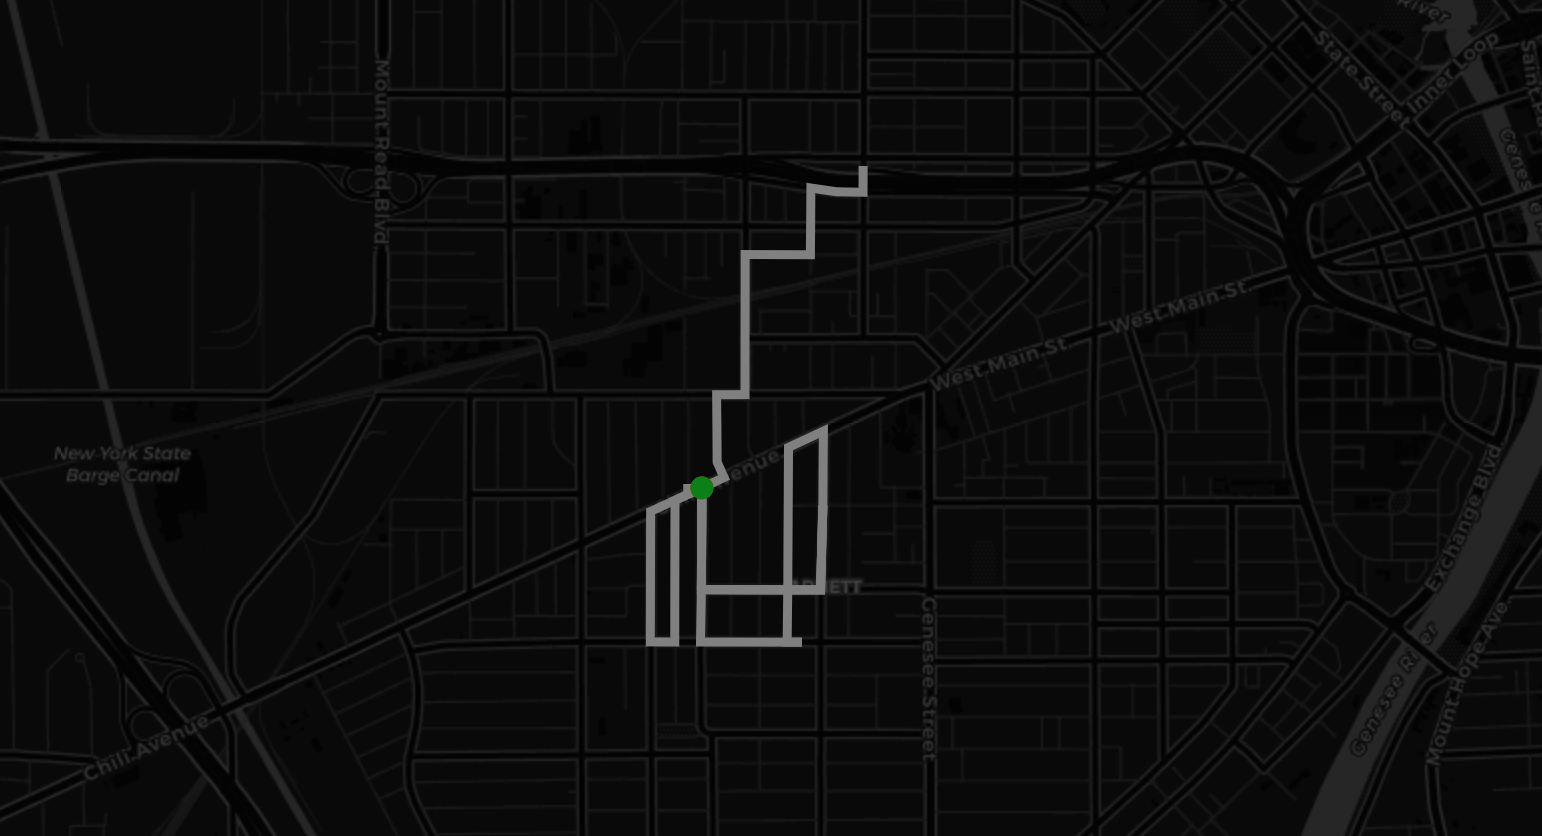

In [456]:
from IPython.display import Image
#Output for traversal of the path becasue the video is not visible on github. The purple circle 
#in the middle traverses the path from source to destination in a video form
Image(filename = "Closest-Police-Station.png", width = 700, height = 400)

In [426]:
G = ox.graph_from_place('Rochester, NY, USA', network_type='drive')

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



In [427]:
print(G.number_of_nodes())
rochester_nodes=G.number_of_nodes()

4804


In [428]:
G.nodes

NodeView((212598799, 212598806, 212598955, 212598957, 212598961, 212598963, 212598966, 212598968, 212598978, 212598981, 212598987, 212598992, 212598998, 212599033, 212599037, 212599040, 212599044, 212599048, 212599067, 212599070, 212599071, 212599109, 212599182, 212599185, 212599187, 212599396, 212599399, 212599402, 212599405, 212599414, 212599417, 212599420, 212599422, 212599425, 212599428, 212599436, 212599439, 212599442, 212599445, 212599449, 212599455, 212599465, 212599482, 212599677, 212599680, 212599683, 212599687, 212599691, 212599695, 212600519, 212600981, 212601236, 212601250, 212601283, 212601389, 212601407, 212601449, 212601473, 212601500, 212601502, 212601979, 212602178, 212602231, 212602245, 212602261, 212602671, 212602711, 212603138, 212603204, 212603207, 212603580, 212603582, 212603586, 212603608, 212603854, 212604378, 212604386, 212604393, 212604397, 212604410, 212604432, 212604523, 212605092, 212605574, 212606996, 212607014, 212607032, 212607173, 212607180, 212607190, 

In [429]:
G.nodes[212598799].get('x')

-77.5947668

In [430]:
long_r = []
lat_r = []
for i in G.nodes:
    long_r.append(G.nodes[i].get('x'))
    lat_r.append(G.nodes[i].get('y'))

In [431]:
long_r

[-77.5947668,
 -77.5938641,
 -77.6129228,
 -77.6086779,
 -77.6050822,
 -77.6037416,
 -77.6010275,
 -77.599883,
 -77.5966459,
 -77.5957254,
 -77.5922047,
 -77.5915458,
 -77.5845795,
 -77.6127904,
 -77.6087191,
 -77.605362,
 -77.6041707,
 -77.599929,
 -77.592876,
 -77.5922625,
 -77.5905078,
 -77.5617954,
 -77.584249,
 -77.5830522,
 -77.5789375,
 -77.645614,
 -77.646919,
 -77.648226,
 -77.648874,
 -77.6298748,
 -77.6303597,
 -77.6311046,
 -77.6319858,
 -77.6327463,
 -77.6335007,
 -77.634838,
 -77.635947,
 -77.637077,
 -77.6382327,
 -77.6394751,
 -77.6406736,
 -77.641866,
 -77.643729,
 -77.563114,
 -77.560993,
 -77.559895,
 -77.558803,
 -77.557713,
 -77.556662,
 -77.6095568,
 -77.6048636,
 -77.6436496,
 -77.6411332,
 -77.6348358,
 -77.5915768,
 -77.6227057,
 -77.6235371,
 -77.6228107,
 -77.5982423,
 -77.5993736,
 -77.5513054,
 -77.6180536,
 -77.6178571,
 -77.6182237,
 -77.595958,
 -77.561443,
 -77.561409,
 -77.5523787,
 -77.5595857,
 -77.5564383,
 -77.5698819,
 -77.575143,
 -77.5795388,
 -

In [432]:
lat_r

[43.1398931,
 43.1414417,
 43.1910702,
 43.1911429,
 43.1913379,
 43.1914463,
 43.1915736,
 43.1916125,
 43.1920375,
 43.1922511,
 43.1929427,
 43.1931084,
 43.1948012,
 43.1917477,
 43.1918183,
 43.1919814,
 43.1920778,
 43.1924107,
 43.1937304,
 43.1938783,
 43.1942986,
 43.196326,
 43.184297,
 43.1843358,
 43.184469,
 43.176866,
 43.176862,
 43.176853,
 43.176852,
 43.178143,
 43.1780135,
 43.1778147,
 43.1775795,
 43.1773764,
 43.1771751,
 43.1769528,
 43.1769433,
 43.1769371,
 43.1769307,
 43.1769238,
 43.1769172,
 43.1769104,
 43.1769,
 43.165532,
 43.165506,
 43.165487,
 43.165468,
 43.165454,
 43.165437,
 43.2553603,
 43.1510976,
 43.1573944,
 43.1564526,
 43.1566819,
 43.1413111,
 43.1925713,
 43.1935827,
 43.1936739,
 43.1609788,
 43.1602599,
 43.1423349,
 43.1914937,
 43.1903133,
 43.1909812,
 43.1924071,
 43.1963311,
 43.1955918,
 43.137074,
 43.144755,
 43.1443297,
 43.1437861,
 43.1434523,
 43.1428991,
 43.1621298,
 43.1557742,
 43.157049,
 43.1571053,
 43.1573599,
 43.15

In [433]:
len(long_r)

4804

In [434]:
len(lat_r)

4804

In [435]:
 43.157178  -77.639264

-34.482085999999995

In [436]:
if 43.1571782 in lat_r:
    print(True)
else:
    print(False)

False


In [437]:
for i in paths_d:
    if i in G.nodes:
        print(i)

212673147.0
212765257
212768219
212643822
212643824
212643845
212905450
212677084
212601250
212669836
212615424


In [438]:
a=0
for i in lat2:
    if i not in lat_r:
        print(i)
        a=a+1
print(a)

43.1463413
43.1463413
43.1471815
43.1471815
43.1427982
43.1427982
43.1422328
43.1422328
43.1423406
43.1424266
43.1425066
43.1477942
43.1478732
43.1479886
43.1493243
43.1493243
43.1506468
43.1506468
43.1540075
43.1543686
43.1543668
43.1543668
43.1543659
43.1543665
43.156253
43.1563043
43.1563509
43.1563849
43.1564122
43.1564401
43.1563598
43.1563506
43.1563428
43.1563355
43.15633
43.1563246
43.156321
43.1563199
43.156391
43.156956
43.1571469
41


In [439]:
len(lat2)

150

In [440]:
for i in pst['lat']:
    if i not in lat_r:
        print(i)
    

43.2128319
43.1688905
43.1571782
43.1211255
43.1125714
43.1268917
43.1606871
43.1518681
43.1578983


In [441]:
for i in pst['point']:
        print(i)

(43.2128319, -77.5818864, 0.0)
(43.1688905, -77.6099545, 0.0)
(43.1571782, -77.6392636, 0.0)
(43.1211255, -77.6519564, 0.0)
(43.1125714, -77.4856604, 0.0)
(43.1268917, -77.5750879, 0.0)
(43.1606871, -77.6220447, 0.0)
(43.1518681, -77.61198783041527, 0.0)
(43.1578983, -77.6065316, 0.0)


In [442]:
new_G = ox.graph_from_place('Rochester, NY', network_type='drive_service')

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



In [443]:
print(new_G.number_of_nodes())


10243


In [444]:
print(G.number_of_nodes())



4804


In [445]:
for i in paths_d:
    if i not in new_G.nodes :
        print(i)

In [446]:
for i in paths_d:
    if i not in G.nodes :
        print(i)

212867077
6954768651
6979932709
8077443706


In [447]:
long_rny = []
lat_rny = []
for i in new_G.nodes:
    long_r.append(new_G.nodes[i].get('x'))
    lat_r.append(new_G.nodes[i].get('y'))

In [448]:
for i in pst['lat']:
    if i not in lat_rny:
        print(i)
    

43.2128319
43.1688905
43.1571782
43.1211255
43.1125714
43.1268917
43.1606871
43.1518681
43.1578983


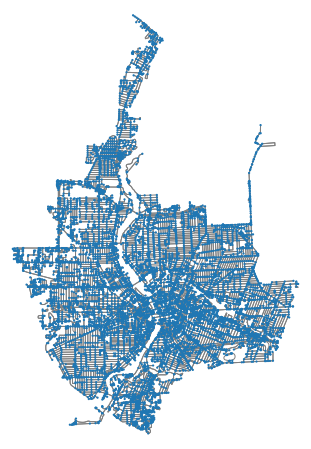

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [449]:
import matplotlib.pyplot as plt 
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(new_G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='gray', node_size=5)

In [450]:
origin_node = ox.nearest_nodes(new_G, pst.loc[first.index(min(first))]["lon"],pst.loc[first.index(min(first))]["lat"])

In [451]:
#origin_node = ox.nearest_nodes(new_G,43.2008845, -77.6596506)
#origin_node = ox.distance.nearest_nodes(new_G, -77.6596506,43.2008845)


In [452]:
paths_d = nx.shortest_path(new_G, mainroute[0],origin_node, weight='travel_time')

In [453]:
mainroute2=mainroute1+paths_d

In [454]:
lines = node_list_to_path2(new_G, mainroute2)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
origin_point = (lat2[0],long2[0]) 
destination_point = (lat2[0],long2[0])
plot_path(lat2, long2, origin_point, destination_point)

In [455]:
new_G.nodes[212605574]

{'y': 43.2008845, 'x': -77.6596506, 'street_count': 3}

In [472]:
G = ox.graph_from_place('Rochester, NY, USA', network_type='drive_service')

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



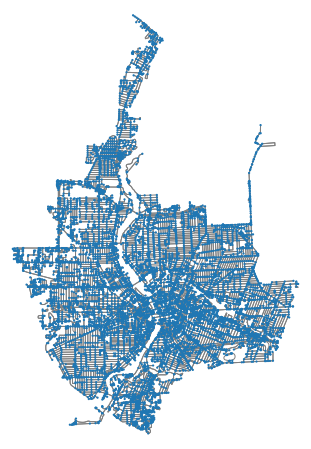

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [473]:
import matplotlib.pyplot as plt 
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='gray', node_size=5)

In [460]:
Sanket_G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive_service')

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



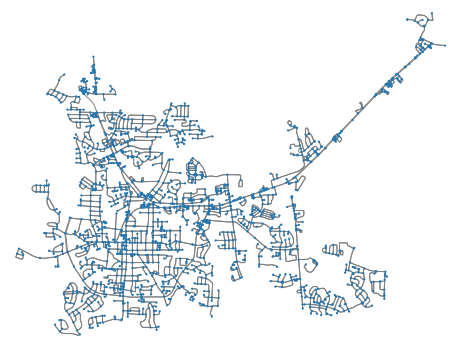

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [461]:
import matplotlib.pyplot as plt 
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(Sanket_G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='gray', node_size=5)

In [464]:
Sanket_G2 = ox.graph_from_place('Fuquay Varina, NC', network_type='drive_service')

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



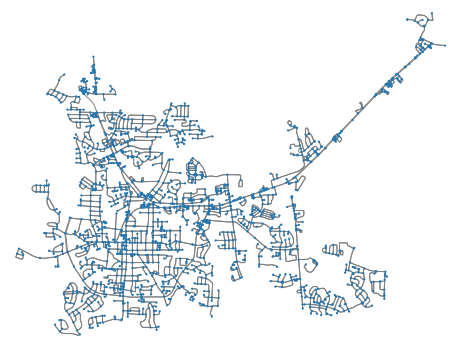

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [465]:
import matplotlib.pyplot as plt 
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(Sanket_G2, bgcolor='#FFFFFF', node_color=colors[0], edge_color='gray', node_size=5)

In [470]:
len(Sanket_G.nodes)

1894

In [471]:
len(Sanket_G2.nodes)

1894